# Modélisation ML — Prédiction du prix de location (Mubawab)

**Objectif :** prédire le **prix (DH)** d’un bien en location à partir de ses caractéristiques :
- ville
- type_bien
- surface
- nb_chambres
- nb_salle_de_bain

**Type de problème :** Régression supervisée.

**Remarque :** Les données immobilières sont souvent très dispersées, donc on utilise une transformation `log(prix)` et on traite les valeurs aberrantes.


1) Imports + chargement des données

In [24]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.max_columns", 50)

DATA_PATH = Path("..") / "data" / "clean_data" / "mubawab_location_all_clean.csv"
assert DATA_PATH.exists(), f"❌ Fichier introuvable: {DATA_PATH}"

df = pd.read_csv(DATA_PATH, encoding="utf-8-sig")
print("Shape:", df.shape)
df.head()


Shape: (3116, 9)


,id,ville,prix,surface,quartier,type_bien,nb_chambres,nb_salle_de_bain,url_annonce
0,1,Casablanca,5800.0,130.0,Val Fleury à Casablanca,Appartement,3,2,https://www.mubawab.ma/fr/a/8279130/appartemen...
1,3,Casablanca,7300.0,63.0,Oulfa à Casablanca,Appartement,1,1,https://www.mubawab.ma/fr/a/8277563/studio-meu...
2,4,Casablanca,7500.0,71.0,Maârif à Casablanca,Appartement,2,1,https://www.mubawab.ma/fr/a/8281617/appartemen...
3,6,Casablanca,9500.0,115.0,Palmier à Casablanca,Appartement,3,2,https://www.mubawab.ma/fr/a/8052585/appartemen...
4,10,Casablanca,26000.0,180.0,Gauthier à Casablanca,Appartement,3,3,https://www.mubawab.ma/fr/a/8242721/appartemen...


2) Préparation ML (features + target + types)

In [26]:
features = ["ville", "type_bien", "surface", "nb_chambres", "nb_salle_de_bain"]
target = "prix"

df_ml = df[features + [target]].copy()

# Conversion des colonnes numériques
for col in ["surface", "nb_chambres", "nb_salle_de_bain", "prix"]:
    df_ml[col] = pd.to_numeric(df_ml[col], errors="coerce")

# Nettoyage minimal: on garde uniquement les lignes complètes
df_ml = df_ml.dropna().reset_index(drop=True)

print("Dataset ML (après dropna):", df_ml.shape)
df_ml.describe()


Dataset ML (après dropna): (3116, 6)


,surface,nb_chambres,nb_salle_de_bain,prix
count,3116.000000,3116.000000,3116.000000,3116.000000
mean,305.427723,2.446085,2.100449,16358.291021
std,3691.186107,1.194684,1.108780,13378.954216
min,10.000000,1.000000,1.000000,500.000000
25%,76.000000,2.000000,1.000000,8000.000000
50%,110.000000,2.000000,2.000000,12000.000000
75%,180.000000,3.000000,3.000000,20000.000000
max,148148.000000,12.000000,11.000000,100000.000000


3) Filtrage métier + suppression d’outliers (INDISPENSABLE)

In [27]:
# 1) Filtre métier simple (location): enlever valeurs irréalistes
df_ml = df_ml[df_ml["prix"].between(500, 100_000)].reset_index(drop=True)

# 2) Filtre prix/m² (cohérence)
df_ml["prix_m2"] = df_ml["prix"] / df_ml["surface"]
df_ml = df_ml[df_ml["prix_m2"].between(10, 2000)].reset_index(drop=True)

# 3) Outliers statistiques (couper 1%-99%)
q1 = df_ml["prix"].quantile(0.01)
q99 = df_ml["prix"].quantile(0.99)
df_ml = df_ml[df_ml["prix"].between(q1, q99)].reset_index(drop=True)

print("Dataset ML après filtres:", df_ml.shape)
df_ml[["prix","surface","prix_m2"]].describe()


Dataset ML après filtres: (3029, 7)


,prix,surface,prix_m2
count,3029.000000,3029.000000,3029.000000
mean,15806.286122,178.725251,111.009499
std,11374.188224,226.551792,43.194076
min,3500.000000,25.000000,10.273973
25%,8000.000000,76.000000,82.352941
50%,12000.000000,110.000000,106.250000
75%,19000.000000,175.000000,135.616438
max,67000.000000,4000.000000,711.111111


4) Target en log (très important)

In [28]:
df_ml["log_prix"] = np.log1p(df_ml["prix"])


5) Split train/test

In [29]:
X = df_ml[features]
y = df_ml["log_prix"]   # on apprend sur log(prix)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (2423, 5) Test: (606, 5)


6) Préprocessing (num + cat)

In [30]:
num_features = ["surface", "nb_chambres", "nb_salle_de_bain"]
cat_features = ["ville", "type_bien"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)


7) Modèles + évaluation

In [31]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
}

results = []

for name, model in models.items():
    pipe = Pipeline([("prep", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae_log = mean_absolute_error(y_test, y_pred)
    rmse_log = (mean_squared_error(y_test, y_pred)) ** 0.5
    r2_log = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MAE_log": mae_log,
        "RMSE_log": rmse_log,
        "R2_log": r2_log
    })

results_df = pd.DataFrame(results).sort_values("R2_log", ascending=False)
results_df


,Model,MAE_log,RMSE_log,R2_log
3,GradientBoosting,0.238032,0.317206,0.699844
2,RandomForest,0.246476,0.329183,0.676749
1,Ridge,0.280524,0.367464,0.597197
0,LinearRegression,0.280200,0.367482,0.597158


In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# On entraîne un RandomForest pour l'interprétation
rf_model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", rf_model)
])

rf_pipe.fit(X_train, y_train)

# Récupérer les noms des features après encodage
ohe = rf_pipe.named_steps["prep"].named_transformers_["cat"]
cat_names = ohe.get_feature_names_out(cat_features)

feature_names = num_features + list(cat_names)
importances = rf_pipe.named_steps["model"].feature_importances_

fi = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

fi.head(10)


,Feature,Importance
0,surface,0.860882
2,nb_salle_de_bain,0.043188
1,nb_chambres,0.034136
5,ville_Rabat,0.020745
4,ville_Marrakech,0.012602
3,ville_Casablanca,0.010485
6,ville_Tanger,0.010311
7,type_bien_Appartement,0.003845
10,type_bien_Villa,0.003318
8,type_bien_Maison,0.000447


<Figure size 800x500 with 0 Axes>

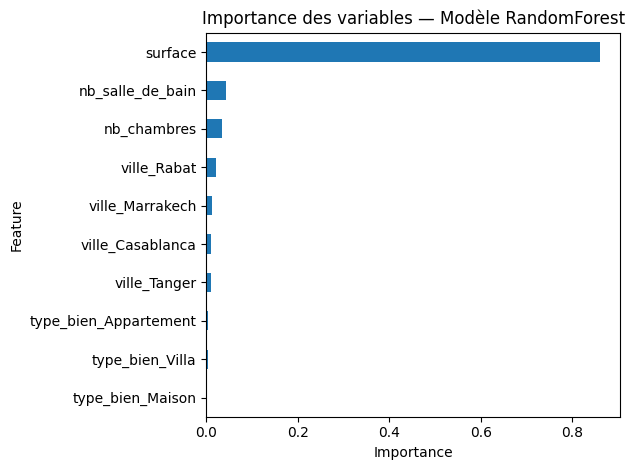

In [35]:
plt.figure(figsize=(8,5))
fi.head(10).sort_values("Importance").plot(
    kind="barh", x="Feature", y="Importance", legend=False
)
plt.title("Importance des variables — Modèle RandomForest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


8) Interprétation en DH (retour en prix réel)

In [36]:
best_model_name = results_df.iloc[0]["Model"]
print("Meilleur modèle:", best_model_name)

best_pipe = Pipeline([("prep", preprocessor), ("model", models[best_model_name])])
best_pipe.fit(X_train, y_train)

pred_log = best_pipe.predict(X_test)

# Retour en DH
pred_prix = np.expm1(pred_log)
true_prix = np.expm1(y_test)

mae_dh = mean_absolute_error(true_prix, pred_prix)
rmse_dh = (mean_squared_error(true_prix, pred_prix)) ** 0.5

print("MAE (DH):", round(mae_dh, 2))
print("RMSE (DH):", round(rmse_dh, 2))


Meilleur modèle: GradientBoosting
MAE (DH): 3684.82
RMSE (DH): 5805.88


9) Importance des variables (si RandomForest est meilleur)

In [37]:
if best_model_name == "RandomForest":
    ohe = best_pipe.named_steps["prep"].named_transformers_["cat"]
    cat_names = ohe.get_feature_names_out(cat_features)
    feature_names = num_features + list(cat_names)

    importances = best_pipe.named_steps["model"].feature_importances_

    fi = pd.DataFrame({"feature": feature_names, "importance": importances})
    fi = fi.sort_values("importance", ascending=False)

    fi.head(20)
else:
    print("Le meilleur modèle n'est pas RandomForest, on saute l'importance.")


Le meilleur modèle n'est pas RandomForest, on saute l'importance.


## Conclusion

- Après nettoyage (valeurs aberrantes + cohérence prix/m²) et transformation log(prix),
  les modèles deviennent capables de prédire le prix de location.
- Les meilleurs modèles attendus sont souvent : RandomForest / GradientBoosting.
- Les facteurs les plus influents : surface, ville, type de bien.


Section : Résultats de la modélisation

Plusieurs modèles de régression ont été évalués afin de prédire le prix de location.
Les modèles non linéaires (Random Forest et Gradient Boosting) surpassent les modèles linéaires, ce qui confirme la nature non linéaire du marché immobilier.
Le modèle Gradient Boosting obtient les meilleures performances avec un coefficient de détermination R² ≈ 0.70, indiquant une bonne capacité de généralisation.